# Flow Network Solver

### General imports

In [1]:
# %pylab
# %run FastFlowNets.py 64 1 0
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys, os
args = sys.argv
sys.executable

import numpy as np
import copy
from numpy import zeros as zeros
from numpy import ones as ones
from numpy import array as array
from numpy import arange as arange
from numpy import meshgrid as meshgrid
from numpy import dot as dot
from numpy.linalg import inv as inv

import numpy.linalg as la
import numpy.random as rand
import pickle
import networkx as nx
import matplotlib.pyplot as plt

# My functions
import NETfuncs, Constraints, Matrixfuncs, Solve, Statistics, Classes

# figures
plt.rcParams['figure.figsize'] = (10,10)

In [2]:
# pip install networkx

### Roie Larger Network

In [3]:
## Prelims - sizes etc.

NGrid = 7  # lattice dimansion is Ngrid X Ngrid 
Periodic = False  # flag for lattice periodicity
net_typ = 'Cells'
K_max = 2
K_min = 0.1
u_thresh = 0.1
input_p = arange(0.3, 1.8, 0.05)
for i in input_p:
    print(i)
# flow_scheme = 'unidir'  # apply pressure drop only in the regular direction - constrained node = positive, ground = 0
flow_scheme = 'taktak'  # apply pressure drop unidir once, then switch ground and constrained nodes to apply oposite dir.
iterations = 10

input_output_pairs = np.array([[204, 44], 
                               [184, 64]])

Variabs = Classes.User_variables(NGrid, Periodic, net_typ, K_max, K_min, u_thresh, input_p, 
                                     flow_scheme, iterations, input_output_pairs)

0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.5999999999999999
0.6499999999999999
0.7
0.7499999999999999
0.7999999999999998
0.8499999999999999
0.8999999999999999
0.95
0.9999999999999998
1.0499999999999998
1.0999999999999999
1.15
1.1999999999999997
1.2499999999999998
1.2999999999999998
1.3499999999999999
1.3999999999999997
1.4499999999999997
1.4999999999999998
1.5499999999999998
1.5999999999999999
1.6499999999999997
1.6999999999999997
1.7499999999999998


In [4]:
## Build Incidence Matrices and vectors of edges

Strctr = Classes.Net_structure()
Strctr.build_incidence(Variabs)

In [5]:
## Initiate Network state and K matrix

State = Classes.Net_state()
State.initiateK(Variabs, Strctr)

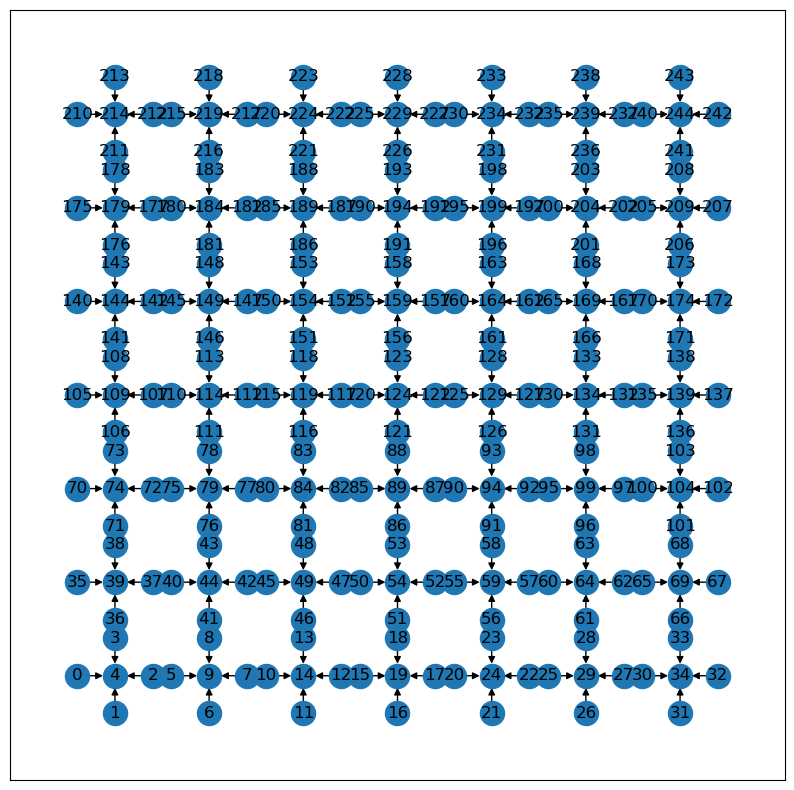

NET is ready


In [6]:
## build network and plot structure

NET = Classes.Networkx_net()
NET.buildNetwork(Strctr)
NET.build_pos_lattice(Variabs)

pressure is 0.3 Hamming is 0.0 flow MSE is 0.0
pressure is 0.3 Hamming is 0.0 flow MSE is 0.0
pressure is 0.3 Hamming is 0.0 flow MSE is 0.0
pressure is 0.3 Hamming is 0.0 flow MSE is 0.0
pressure is 0.3 Hamming is 0.0 flow MSE is 0.0
pressure is 0.3 Hamming is 0.0 flow MSE is 0.0
pressure is 0.35 Hamming is 0.0 flow MSE is 0.0
pressure is 0.35 Hamming is 0.0 flow MSE is 0.0
pressure is 0.35 Hamming is 0.0 flow MSE is 0.0
pressure is 0.35 Hamming is 0.0 flow MSE is 0.0
pressure is 0.35 Hamming is 0.0 flow MSE is 0.0
pressure is 0.35 Hamming is 0.0 flow MSE is 0.0
pressure is 0.39999999999999997 Hamming is 0.0 flow MSE is 0.0
pressure is 0.39999999999999997 Hamming is 0.0 flow MSE is 0.0
pressure is 0.39999999999999997 Hamming is 0.0 flow MSE is 0.0
pressure is 0.39999999999999997 Hamming is 0.0 flow MSE is 0.0
pressure is 0.39999999999999997 Hamming is 0.0 flow MSE is 0.0
pressure is 0.39999999999999997 Hamming is 0.0 flow MSE is 0.0
pressure is 0.44999999999999996 Hamming is 0.0 flow 

pressure is 1.2999999999999998 Hamming is 0.061224489795918366 flow MSE is 0.005444590168897713
pressure is 1.2999999999999998 Hamming is 0.04081632653061224 flow MSE is 0.012678249059161678
pressure is 1.2999999999999998 Hamming is 0.04081632653061224 flow MSE is 0.0053191827285816165
pressure is 1.2999999999999998 Hamming is 0.0 flow MSE is 0.0
pressure is 1.2999999999999998 Hamming is 0.0 flow MSE is 0.0
pressure is 1.2999999999999998 Hamming is 0.0 flow MSE is 0.0
pressure is 1.3499999999999999 Hamming is 0.10204081632653061 flow MSE is 0.0037624603833146778
pressure is 1.3499999999999999 Hamming is 0.04081632653061224 flow MSE is 0.010034403412244559
pressure is 1.3499999999999999 Hamming is 0.04081632653061224 flow MSE is 0.0035921983066714187
pressure is 1.3499999999999999 Hamming is 0.0 flow MSE is 0.0
pressure is 1.3499999999999999 Hamming is 0.0 flow MSE is 0.0
pressure is 1.3499999999999999 Hamming is 0.0 flow MSE is 0.0
pressure is 1.3999999999999997 Hamming is 0.1224489795

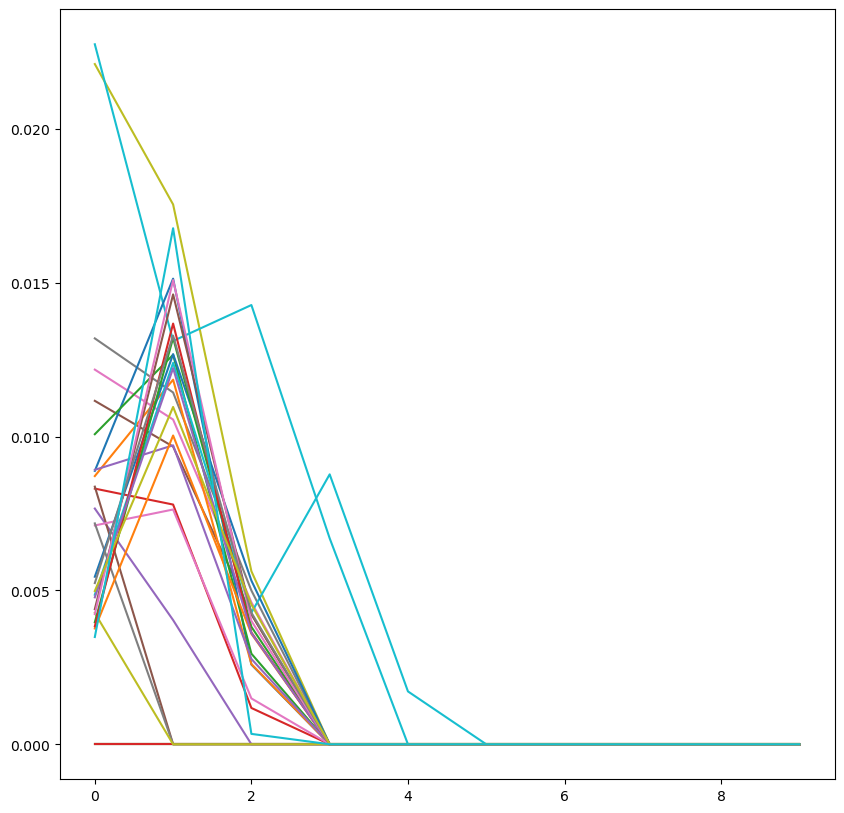

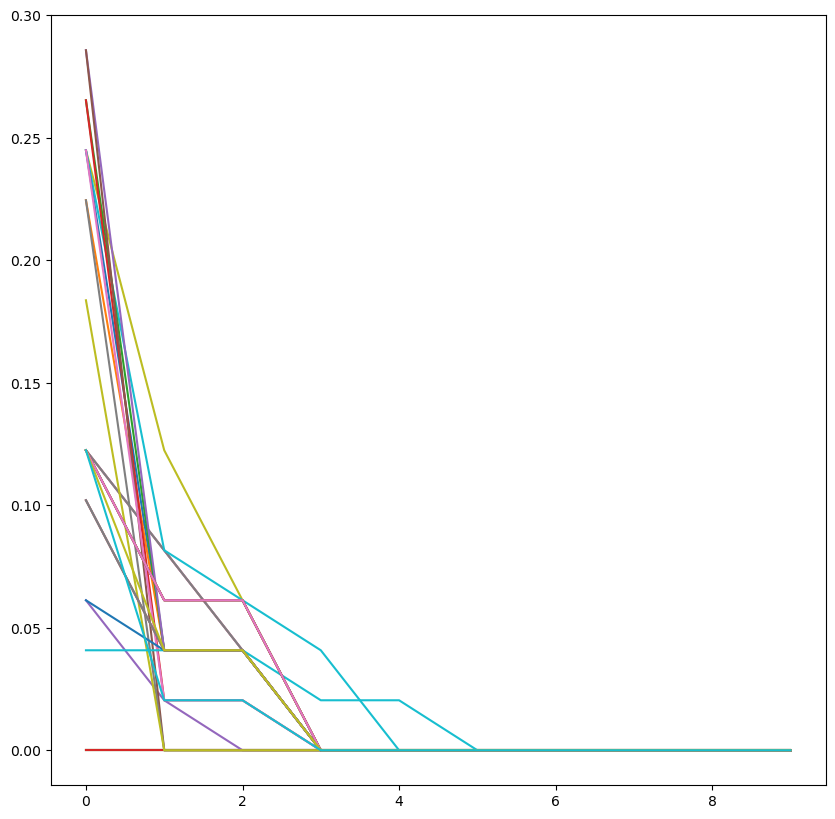

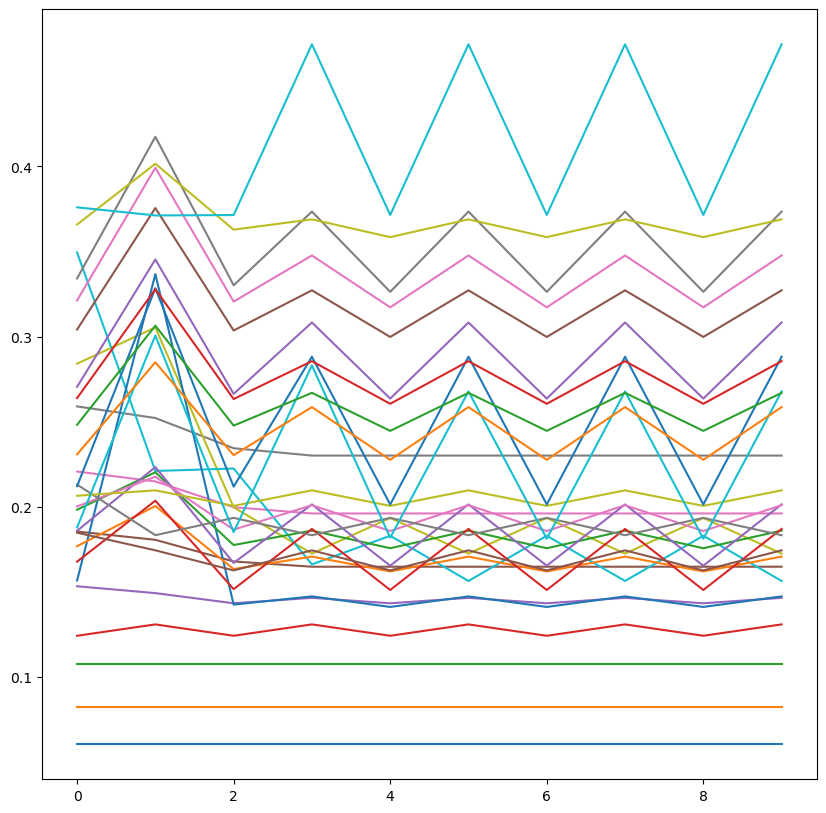

In [7]:
# flow MSE and conductivity Hamming a.f.o input pressure

# Initiate MSE and Hamming matrices - MSE and Hamming for every iteration step (cols) a.f.o input p (rows)
MSE_arr = np.zeros([Variabs.iterations, len(input_p)])
Hamming_arr = np.zeros([Variabs.iterations, len(input_p)])
power_dissip_vec = np.zeros([Variabs.iterations, len(input_p)])

for i, p in enumerate(input_p):
    # save variables into class
    Variabs.assign_input_p(p)
    
    # Identify edges at connections of cells and at boundaries for ease of use
    Strctr.Boundaries_and_connections(Variabs)
    
    # Set up constraints for whole loop
    Strctr.Setup_constraints(Variabs)
    
    # Initiate K matrix again, not mandatory, better not doing it actually
    State.initiateK(Variabs, Strctr)
    
    # Loop - Pose constraints, build constraints matrix, solve flow and update conductivities until convergence,
    #        change constraints and repeat
    State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')
    
    MSE_arr[:, i] = State.MSE
    Hamming_arr[:, i] = State.Hamming
    # print(State.power_dissip)
    power_dissip_vec[:, i] = State.power_dissip

[0.01116065 0.00967378 0.00422838 0.         0.         0.
 0.         0.         0.         0.        ]


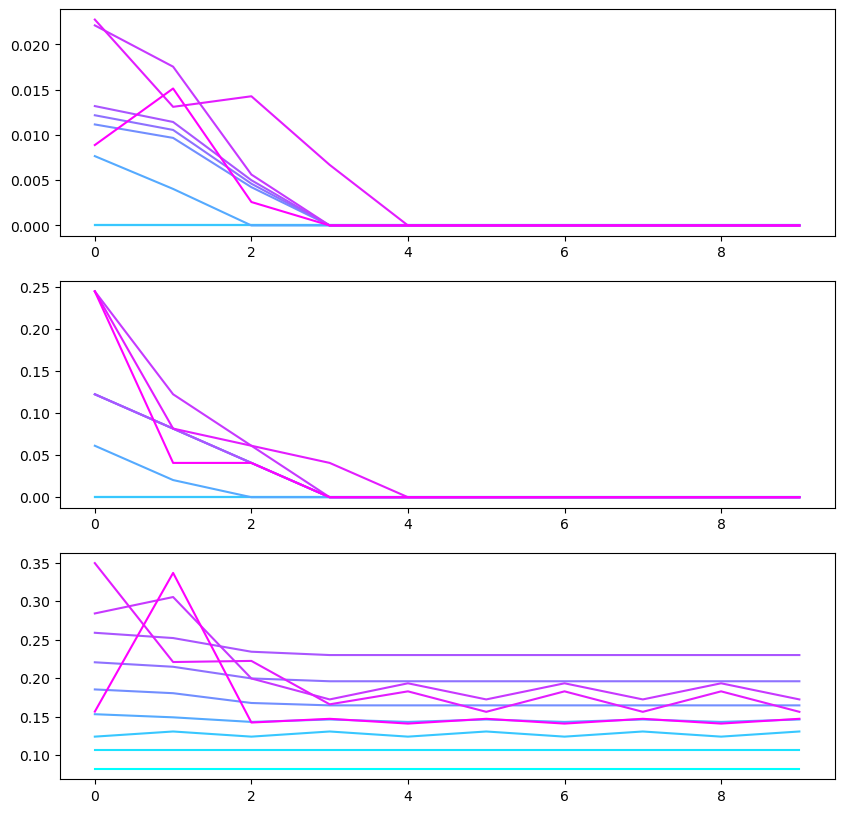

In [40]:
fig, axes = plt.subplots(nrows=3)
# axes.set_color_cycle(['332288', '88CCEE', '44AA99', '117733', '999933', 'DDCC77', 'CC6677', '882255', 'AA4499'])
cmap = plt.get_cmap('cool')
colors = [cmap(i) for i in np.linspace(0, 1, len(MSE_arr[:,0]))]

print(MSE_arr[:,5])
for i, color in enumerate(colors, start=1):
    axes[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color, label='$y = {i}x + {i}$'.format(i=i))
    axes[1].plot(range(len(MSE_arr[:,0])), Hamming_arr[:,i], color=color, label='$y = {i}x + {i}$'.format(i=i))
    axes[2].plot(range(len(MSE_arr[:,0])), power_dissip_vec[:,i], color=color, label='$y = {i}x + {i}$'.format(i=i))
plt.show()

# axes[0].plot(MSE_arr)
# axes[1].plot(Hamming_arr)
# axes[2].plot(power_dissip_vec)

In [8]:
plot = 'last'
iters = 32
i = 30
if plot == 'yes' or plot == 'last' and (i == (iters - 1) or i == (iters - 2)):
    print('bool')

bool


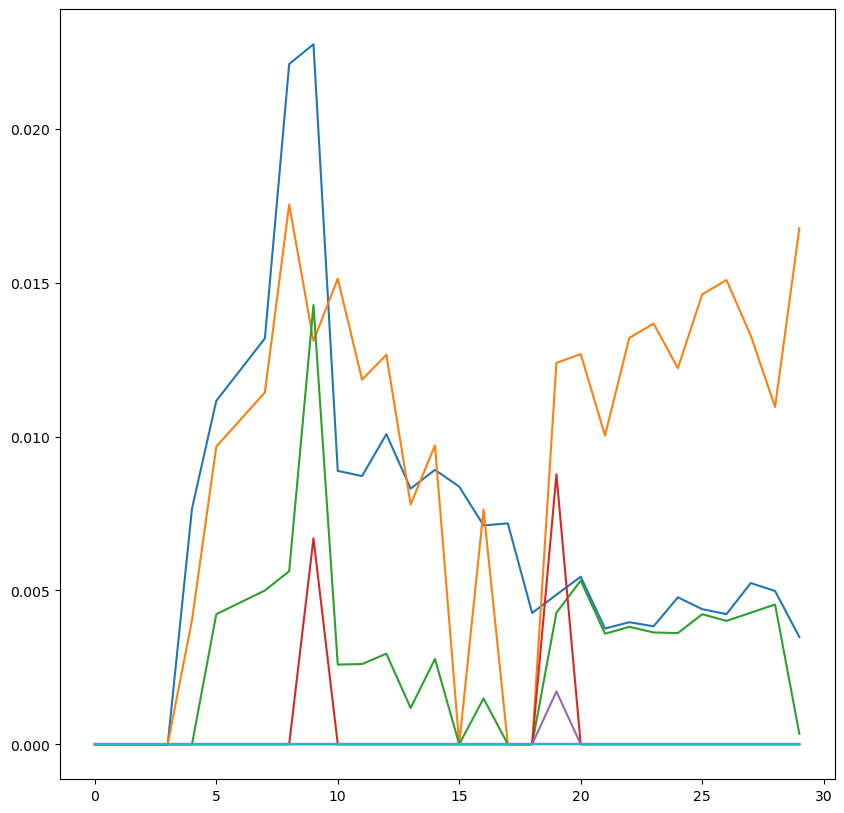

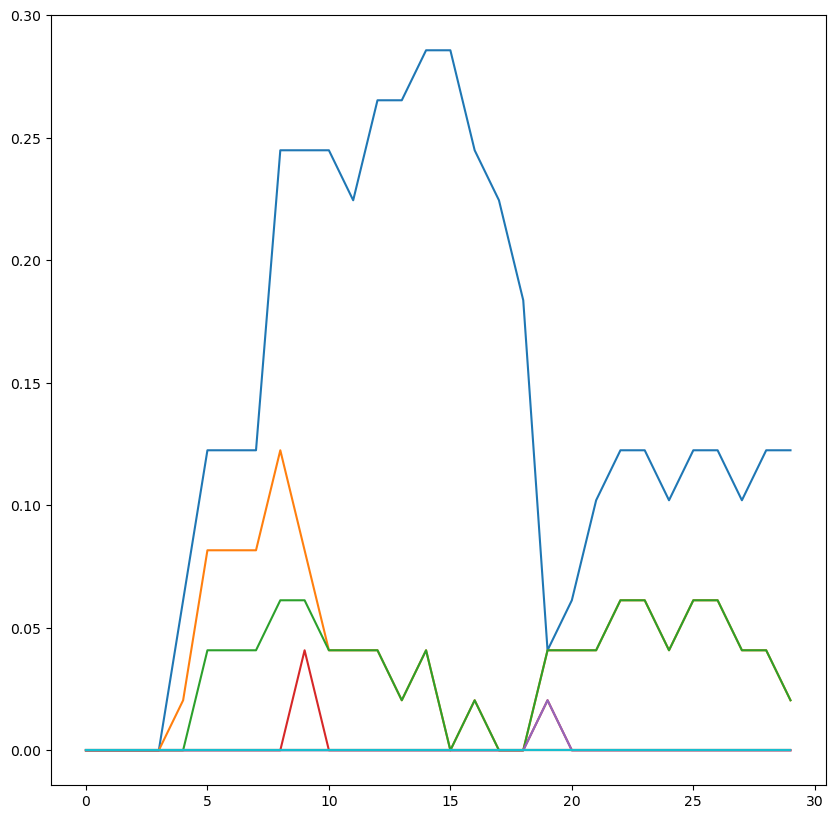

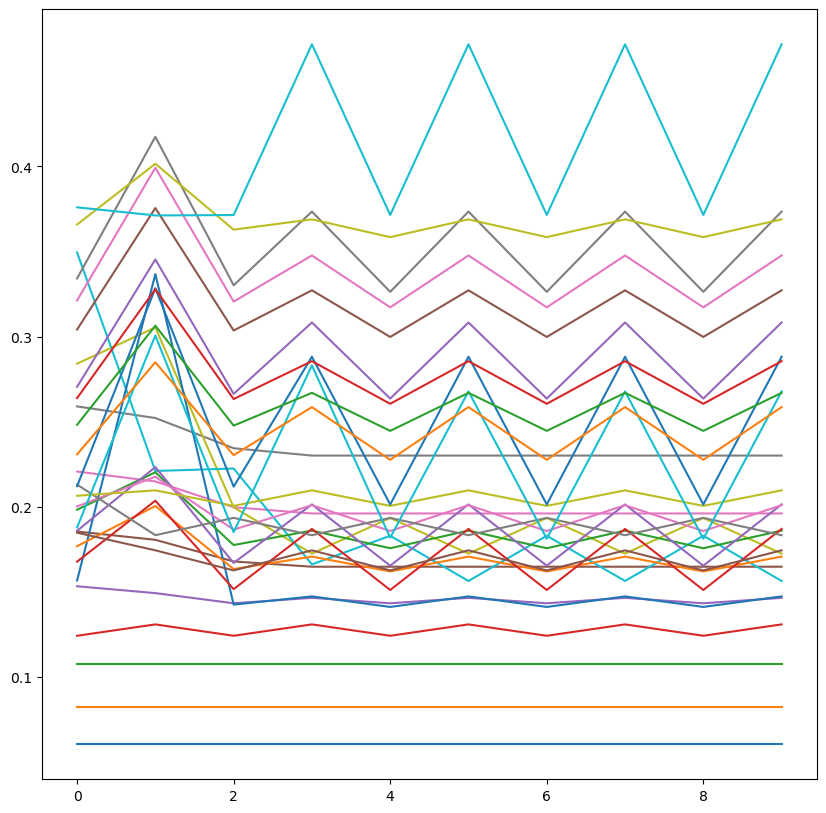

In [9]:
plt.plot(MSE_arr.T)
plt.show()
plt.plot(Hamming_arr.T)
plt.show()
plt.plot(power_dissip_vec)
plt.show()

In [10]:
np.sum(State.u_all[:,1]**2/State.K_all[:,1])

0.3711859264488074

In [11]:
## Identify edges at connections of cells and at boundaries for ease of use

Strctr.Boundaries_and_connections(Variabs)

In [12]:
## Set up constraints for whole loop

Strctr.Setup_constraints(Variabs)

In [13]:
## Background flow - all outputs open, each input

State.flow_iterate(Variabs, Strctr, NET, 'no marbles', 'no')

u_final_noCond = State.u_final
print(u_final_noCond)

[[0.10906861 0.44891822]
 [0.110619   0.20597321]]


In [14]:
## Initiate K matrix again, not mandatory, better not doing it actually

State.initiateK(Variabs, Strctr)

In [15]:
## Loop - Pose constraints, build constraints matrix, solve flow and update conductances until convergence,
##        change constraints and repeat

State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')               

pressure is 1.7499999999999998 Hamming is 0.12244897959183673 flow MSE is 0.003485777645212948
pressure is 1.7499999999999998 Hamming is 0.02040816326530612 flow MSE is 0.01677061821357161
pressure is 1.7499999999999998 Hamming is 0.02040816326530612 flow MSE is 0.00033753740841015623
pressure is 1.7499999999999998 Hamming is 0.0 flow MSE is 0.0
pressure is 1.7499999999999998 Hamming is 0.0 flow MSE is 0.0
pressure is 1.7499999999999998 Hamming is 0.0 flow MSE is 0.0


[0.00348578 0.01677062 0.00033754 0.         0.         0.
 0.         0.         0.         0.        ]
[0.12244898 0.02040816 0.02040816 0.         0.         0.
 0.         0.         0.         0.        ]


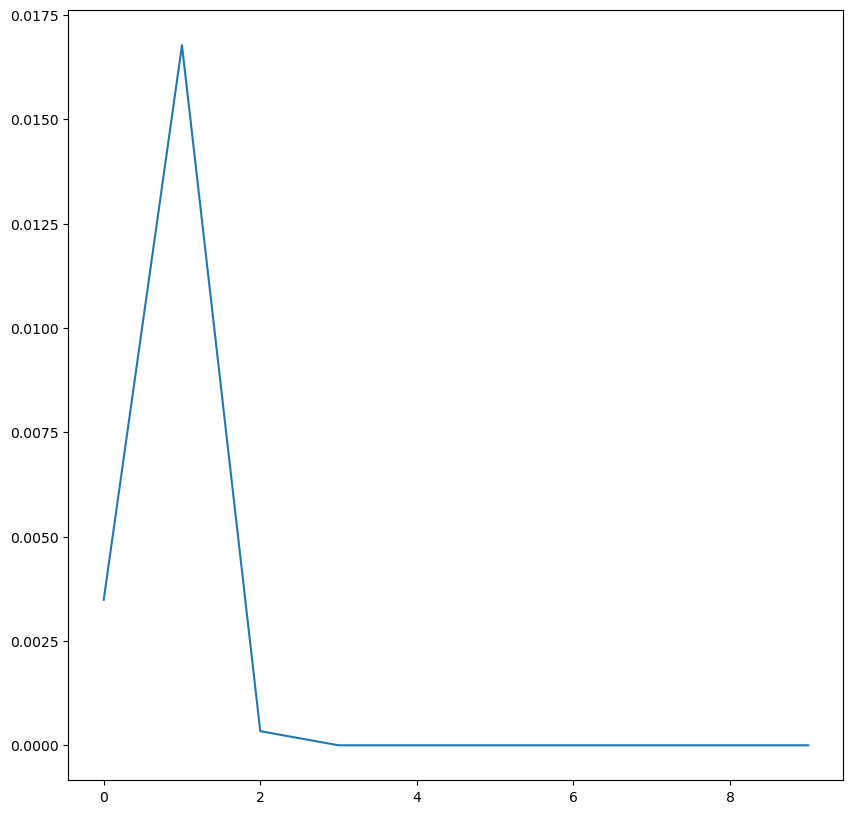

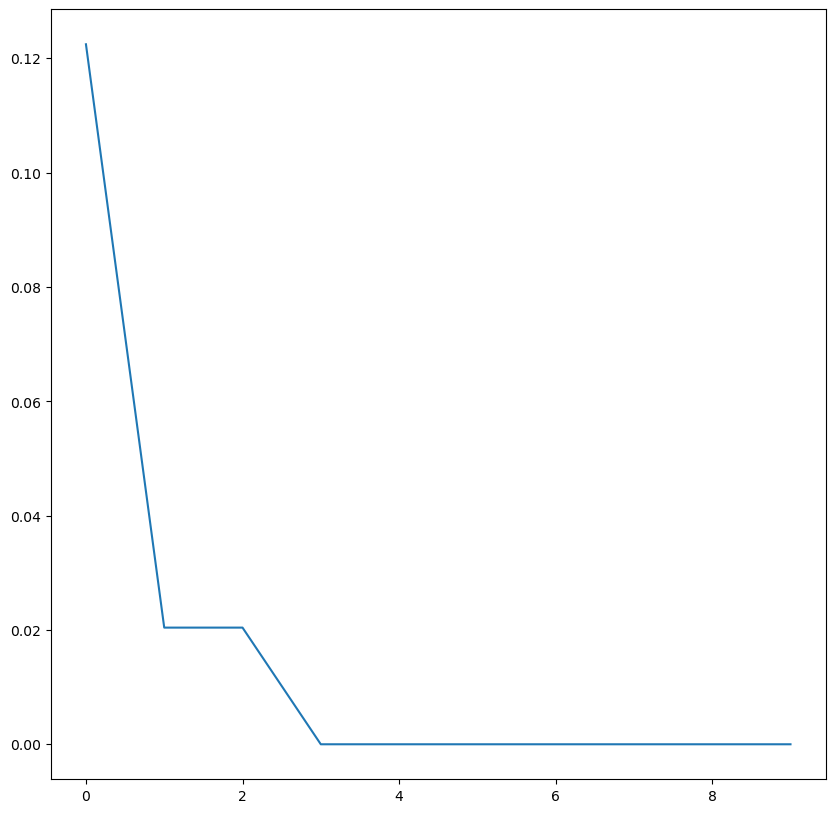

In [16]:
if Variabs.flow_scheme == 'taktak':
    MSE = Statistics.flow_MSE(State.u_all, 4)
    Hamming = Statistics.K_Hamming(State.K_cells, 4)
elif Variabs.flow_scheme == 'unidir':
    MSE = Statistics.flow_MSE(State.u_all, 2)
    Hamming = Statistics.K_Hamming(State.K_cells, 2)
print(MSE)
print(Hamming)

plt.plot(MSE)
plt.show()

plt.plot(Hamming)
plt.show()

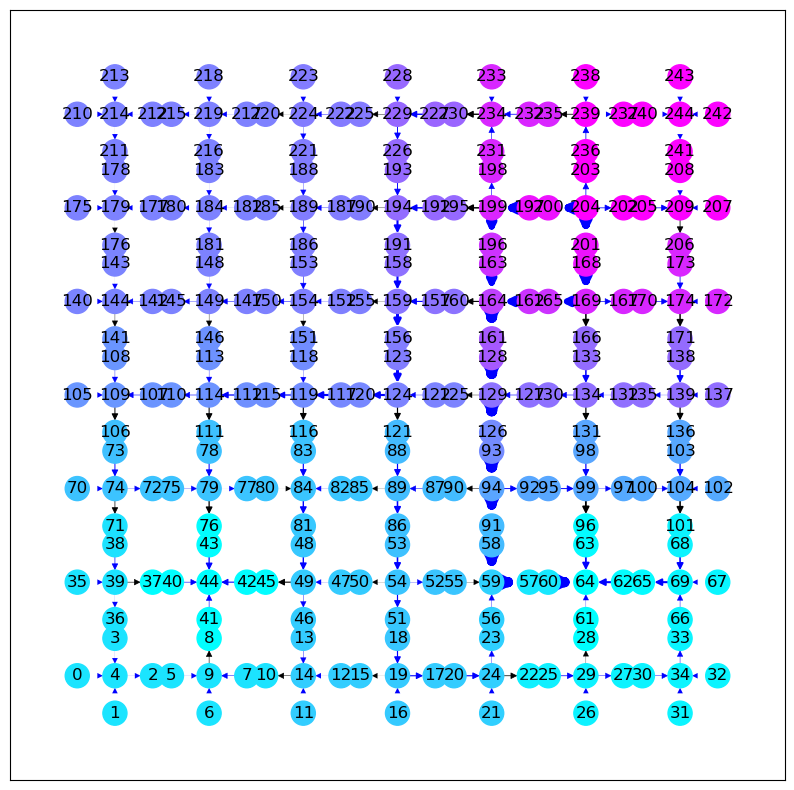

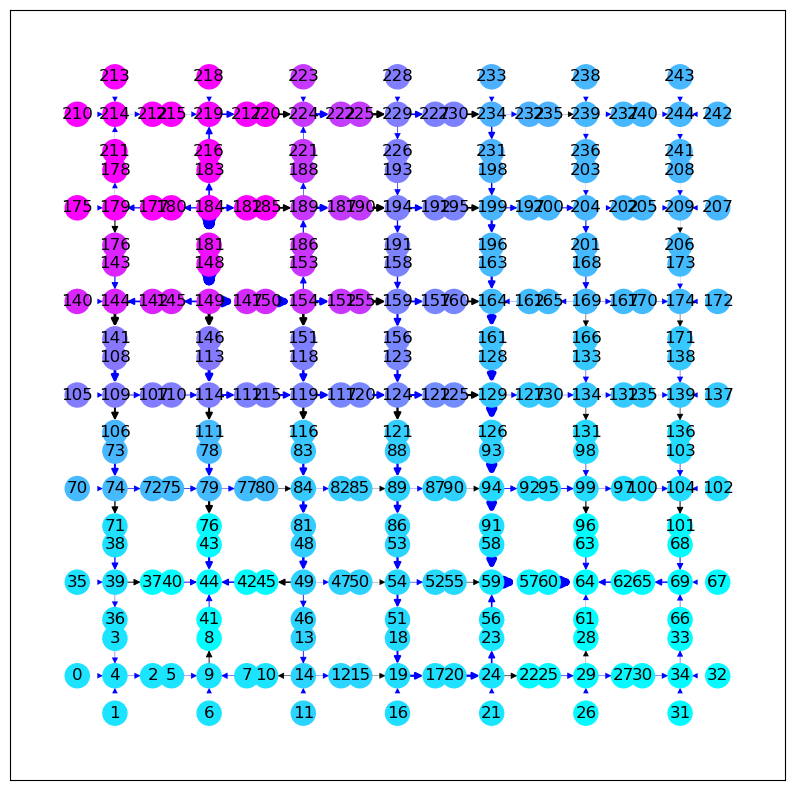

In [17]:
## Allostery Test

State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')  

In [18]:
u_final_cond = State.u_final

print('pushing from ' + str(Strctr.Nodes_full[0]))
print('out of edge ' + str(Strctr.GroundNodes_full[0]) + ' flows ' + str(u_final_Cond[0,0]))
print('and out of edge ' + str(Strctr.GroundNodes_full[1]) + ' flows ' + str(u_final_Cond[0,1]))
print('pushing from ' + str(Strctr.Nodes_full[1]))
print('out of edge ' + str(Strctr.GroundNodes_full[0]) + ' flows ' + str(u_final_Cond[1,0]))
print('and out of edge ' + str(Strctr.GroundNodes_full[1]) + ' flows ' + str(u_final_Cond[1,1]))

pushing from [204]


NameError: name 'u_final_Cond' is not defined

In [ ]:
u_final_norm = u_final_cond/u_final_noCond
print(u_final_cond)
print(u_final_noCond)

print(u_final_norm)

for i in range(2):
    print('for node ' + str(Strctr.Nodes_full[i][0]) + ' the lower velocity is at ' + 
          str(Strctr.GroundNodes_full[np.where(u_final_norm[:,i] == min(u_final_norm[:,i]))[0][0]]))

### Roie Very Simple Net

A net of a single cross 

<div>
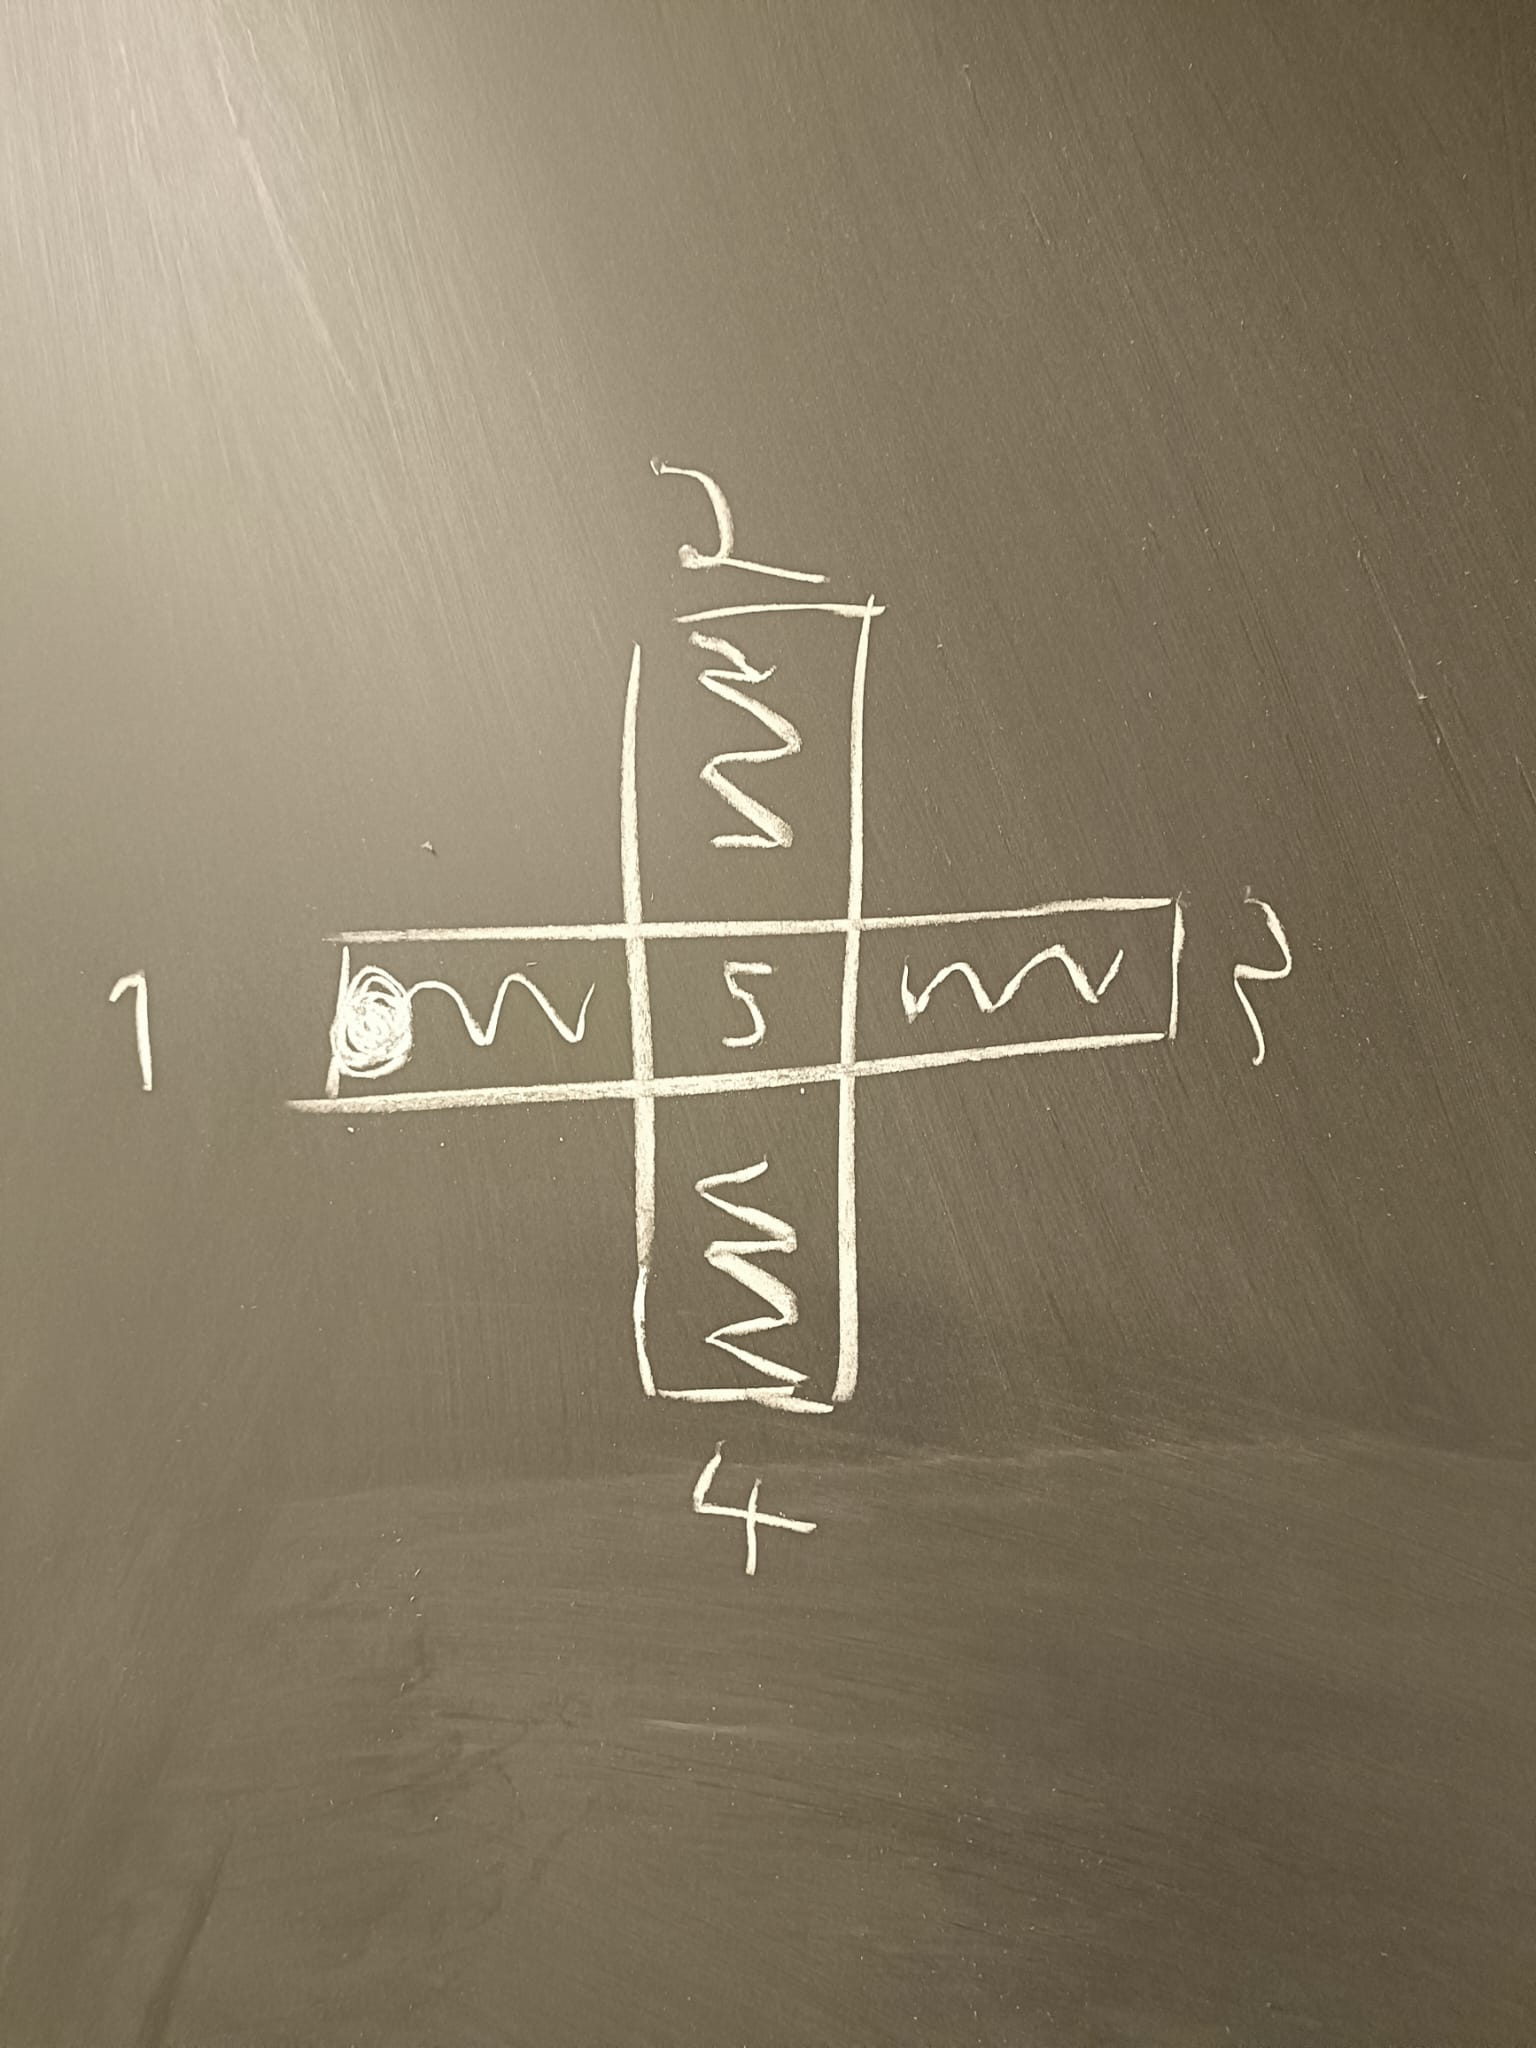
</div>

In [ ]:
## Not in use - keep just in case I can't recover from Git

In [ ]:
# # Build Incidence Matrices and vectors of edges

# EI, EJ, EIEJ_plots, DM, NE, NN = Matrixfuncs.build_incidence(Variabs)     
# Structure = Classes.Net_structure(EI, EJ, EIEJ_plots, DM, NE, NN)

In [ ]:
## Initiate K matrix

# K, K_mat = Matrixfuncs.initiateK(NE, K_max)

In [ ]:
## build network and plot structure

# NET = NETfuncs.buildNetwork(EIEJ_plots)
# pos_lattice = NETfuncs.plotNetStructure(NET, 'Cells')

In [ ]:
## Identify edges at connections of cells and at boundaries for ease of use

# NConncetions = int(NGrid*(NGrid-1)*2)
# EdgesConnections = [int(i) for i in range(NE-NConncetions, NE)]

# NBoundaries = NGrid*4
# left_side = [0 + 4*NGrid*i for i in range(NGrid)]
# bottom_side = [1 + 4*i for i in range(NGrid)]
# right_side = [2 + 4*(NGrid-1) + 4*NGrid*i for i in range(NGrid)]
# top_side = [4*NGrid*(NGrid-1) + 3 + 4*i for i in range(NGrid)]
# EdgesBounaries = np.append(left_side, np.append(bottom_side, np.append(right_side, top_side)))
# # EdgesBounaries = np.array([], int)
# EdgesTotal = np.append(EdgesConnections, EdgesBounaries)

In [ ]:
## Set up constraints for whole loop

# NodeData_full = array([[input_p], [input_p]])  # input p value
# # Nodes_full = array([[6], [35]])  # input p node
# Nodes_full = array([[input_output_pairs[i, 0]] for i in range(len(input_output_pairs))])  # input p node


# GroundNodes_full = array([[input_output_pairs[i, 1]] for i in range(len(input_output_pairs))])  # nodes with zero pressure
# GroundNodes_full_Allostery = array([GroundNodes_full[i][0] for i in range(len(GroundNodes_full))])

# EdgeData_full = array([[0], [0]])  # pressure drop value on edge

# # Edges_full = array([EdgesTotal[(EdgesTotal!=np.where(EI==Nodes_full[0])[0][0]) 
# #                                & (EdgesTotal!=np.where(EI==GroundNodes_full[0])[0][0]) 
# #                                & (EdgesTotal!=np.where(EI==GroundNodes_full[1])[0][0])], 
# #                     EdgesTotal[(EdgesTotal!=np.where(EI==Nodes_full[1])[0][0]) 
# #                                & (EdgesTotal!=np.where(EI==GroundNodes_full[0])[0][0]) 
# #                                & (EdgesTotal!=np.where(EI==GroundNodes_full[1])[0][0])]])

# # Edges_full_Allostery = array([EdgesTotal[(EdgesTotal!=np.where(EI==Nodes_full[0])[0][0]) 
# #                                          & (EdgesTotal!=np.where(EI==GroundNodes_full[0])[0][0]) 
# #                                          & (EdgesTotal!=np.where(EI==GroundNodes_full[1])[0][0])], 
# #                               EdgesTotal[(EdgesTotal!=np.where(EI==Nodes_full[1])[0][0]) 
# #                                          & (EdgesTotal!=np.where(EI==GroundNodes_full[0])[0][0]) 
# #                                          & (EdgesTotal!=np.where(EI==GroundNodes_full[1])[0][0])]])

# Edges_full = array([EdgesTotal[(EdgesTotal!=np.where(EJ==Nodes_full[0])[0][0]) 
#                                & (EdgesTotal!=np.where(EJ==GroundNodes_full[0])[0][0]) 
#                                & (EdgesTotal!=np.where(EJ==GroundNodes_full[1])[0][0])], 
#                     EdgesTotal[(EdgesTotal!=np.where(EJ==Nodes_full[1])[0][0]) 
#                                & (EdgesTotal!=np.where(EJ==GroundNodes_full[0])[0][0]) 
#                                & (EdgesTotal!=np.where(EJ==GroundNodes_full[1])[0][0])]])

# Edges_full_Allostery = array([EdgesTotal[(EdgesTotal!=np.where(EJ==Nodes_full[0])[0][0]) 
#                                          & (EdgesTotal!=np.where(EJ==GroundNodes_full[0])[0][0]) 
#                                          & (EdgesTotal!=np.where(EJ==GroundNodes_full[1])[0][0])], 
#                               EdgesTotal[(EdgesTotal!=np.where(EJ==Nodes_full[1])[0][0]) 
#                                          & (EdgesTotal!=np.where(EJ==GroundNodes_full[0])[0][0]) 
#                                          & (EdgesTotal!=np.where(EJ==GroundNodes_full[1])[0][0])]])

# # Edges_full = array([EdgesConnections, EdgesConnections])
# # output_edges = [np.where(np.append(EI, EJ)==GroundNodes_full[i])[0][0] % len(EI) for i in range(len(GroundNodes_full))]
# output_edges = np.array([np.where(np.append(EI, EJ)==GroundNodes_full[i])[0] % len(EI) 
#                          for i in range(len(GroundNodes_full))])

In [ ]:
## Solve flow with no marbles, i.e. uniform high conductance, for normalization of flow

# u_final_noCond = zeros([2, 2])

# for i in range(2):
#     NodeData = NodeData_full[i] 
#     Nodes = Nodes_full[i] 
#     EdgeData = EdgeData_full[i]
#     Edges = Edges_full[i]
#     GroundNodes = array([GroundNodes_full[0][0], GroundNodes_full[1][0]])
    
#     Cstr_full, Cstr, f = Constraints.ConstraintMatrix(NodeData, Nodes, EdgeData, Edges, GroundNodes, NN, EI, EJ)  # As matrix

#     L, L_bar = Matrixfuncs.buildL(DM, K_mat, Cstr, NN)

#     p, u = Solve.Solve_flow(L_bar, EI, EJ, K, f)
    
#     # correct for very low velocities
#     u[abs(u)<10**-10] = 0

#     # NETfuncs.PlotNetwork(p, u, K, NET, pos_lattice, EIEJ_plots, NN, NE) 
        
#     # u_final_noCond[i,:] = u[output_edges]
#     u_final_noCond[i,:] = [np.sum(u[output_edges[0]]), np.sum(u[output_edges[1]])]

In [ ]:
# def flow_iterate(iterations, NodeData, Nodes, EdgeData, Edges, GroundNodes, output_edges, DM, K_mat, NN, EI, EJ, flow_scheme, 
#                  sim_type='w marbles', plot='yes'):
    
#     u_final = zeros([2, 2])
#     u_all = np.zeros([NE, iterations])

#     for i in range(iterations):
#         m = i % 2

#         # this is the normal direction of flow

#         NodeData = NodeData_full[m] 
#         Nodes = Nodes_full[m] 
#         EdgeData = EdgeData_full[m]
#         Edges = Edges_full[m]
#         GroundNodes = GroundNodes_full[m]

#         # switch ground and input nodes every 2nd iteration 
#         if i % 4 > 1 and flow_scheme == 'taktak':
#             Nodes = GroundNodes_full[m] 
#             GroundNodes = Nodes_full[m]

#         # As matrix
#         Cstr_full, Cstr, f = Constraints.ConstraintMatrix(NodeData, Nodes, EdgeData, Edges, GroundNodes, NN, EI, EJ)  

#         for l in range(3):

#             L, L_bar = Matrixfuncs.buildL(DM, K_mat, Cstr, NN)

#             p, u = Solve.Solve_flow(L_bar, EI, EJ, K, f)

#             # correct for very low velocities
#             u[abs(u)<10**-10] = 0 
            
#             if sim_type == 'w marbles':
#                 K_nxt = Matrixfuncs.ChangeKFromFlow(u, u_thresh, K, K_max, K_min, NGrid)
#                 K_mat = np.eye(NE) * K_nxt
#                 K = copy.copy(K_nxt) 
        
#         if sim_type == 'Allostery test' or sim_type == 'no marbles':
#             u_final[i,:] = [np.sum(u[output_edges[0]]), np.sum(u[output_edges[1]])]
#         else:
#             # p_all[:, i] = p
#             u_all[:, i] = u

#         if plot == 'yes':
#             NETfuncs.PlotNetwork(p, u, K, NET, pos_lattice, EIEJ_plots, NN, NE) 
#     return u_final, u_all, K_mat

In [ ]:
## Loop while changing conductivities

# u_all = np.zeros([NE, iterations])
# for i in range(iterations):
#     m = i % 2
    
#     # this is the normal direction of flow
    
#     NodeData = NodeData_full[m] 
#     Nodes = Nodes_full[m] 
#     EdgeData = EdgeData_full[m]
#     Edges = Edges_full[m]
#     GroundNodes = GroundNodes_full[m]
    
#     # switch ground and input nodes every 2nd iteration 
#     if i % 4 > 1 and flow_scheme == 'taktak':
#         Nodes = GroundNodes_full[m] 
#         GroundNodes = Nodes_full[m]
    
#     # As matrix
#     Cstr_full, Cstr, f = Constraints.ConstraintMatrix(NodeData, Nodes, EdgeData, Edges, GroundNodes, NN, EI, EJ)  
    
#     for l in range(3):

#         L, L_bar = Matrixfuncs.buildL(DM, K_mat, Cstr, NN)

#         p, u = Solve.Solve_flow(L_bar, EI, EJ, K, f)
        
#         # correct for very low velocities
#         u[abs(u)<10**-10] = 0

#         # NETfuncs.PlotNetwork(p, u, K, NET, pos_lattice, EIEJ_plots, NN, NE)

#         K_nxt = Matrixfuncs.ChangeKFromFlow(u, u_thresh, K, K_max, K_min, NGrid)
#         K_mat = np.eye(NE) * K_nxt
#         K = copy.copy(K_nxt)  
    
#     # p_all[:, i] = p
#     u_all[:, i] = u

In [ ]:
## Allostery Check

# u_final_cond = zeros([2,2])

# for i in range(2):
#     NodeData = NodeData_full[i] 
#     Nodes = Nodes_full[i] 
#     EdgeData = EdgeData_full[i]
#     Edges = Edges_full_Allostery[i]
#     GroundNodes = GroundNodes_full_Allostery
    
#     Cstr_full, Cstr, f = Constraints.ConstraintMatrix(NodeData, Nodes, EdgeData, Edges, GroundNodes, NN, EI, EJ)  # As matrix

#     L, L_bar = Matrixfuncs.buildL(DM, K_mat, Cstr, NN)

#     p, u = Solve.Solve_flow(L_bar, EI, EJ, K, f)
    
#     # correct for very low velocities
#     u[abs(u)<10**-10] = 0

#     NETfuncs.PlotNetwork(p, u, K, NET, pos_lattice, EIEJ_plots, NN, NE)

#     # u_final_cond[i,:] = u[output_edges]
#     u_final_cond[i,:] = [np.sum(u[output_edges[0]]), np.sum(u[output_edges[1]])]